In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
import seaborn as sns
#supress update on pandas regarding TargetEncoding
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = fetch_openml("credit-g")
X = data.data
y = data.target
print(data.DESCR)

**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
Good  Bad (predicted)  
Good   0    1 (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of disposable income  
9. Persona

In [2]:
data.data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [3]:
#Helper Functions
def name_plot(ax, title=None, x_label=None, y_label=None):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return

def score_model(model, X, y, scoring=['accuracy'], cv=5):
    #sklearn default for classification cross validation is StratifiedKFold, no need to change
    results = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    for metric in scoring:
        score = results['test_' + metric].mean()
        std = results['test_' + metric].std()
        print(f'{metric.capitalize()} score: {score:.3f}, std: {std:.3f}')

# Inspecting Target

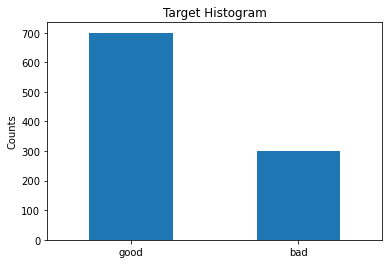

In [4]:
ax = y.value_counts().plot(kind='bar')
name_plot(ax, 'Target Histogram', y_label='Counts')
ax.tick_params(rotation=0)

# Continuous Features

In [5]:
cont = X.select_dtypes(np.number).columns.values.tolist()
X[cont].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   duration                1000 non-null   float64
 1   credit_amount           1000 non-null   float64
 2   installment_commitment  1000 non-null   float64
 3   residence_since         1000 non-null   float64
 4   age                     1000 non-null   float64
 5   existing_credits        1000 non-null   float64
 6   num_dependents          1000 non-null   float64
dtypes: float64(7)
memory usage: 54.8 KB


No missing values

In [6]:
X[cont].head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0


<AxesSubplot:>

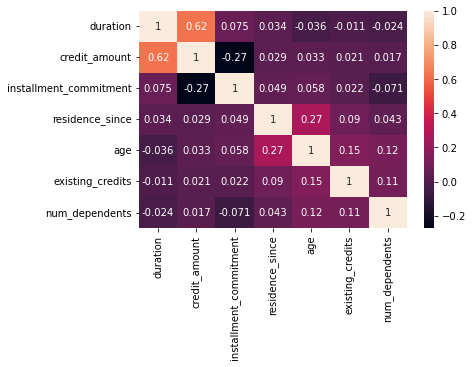

In [7]:
sns.heatmap(X.corr(), annot=True)

Correlation between credit_amount and duration.  
Need to find average correlation between each of them and other variables.  The column with highest mean correlation will be removed.  


In [8]:
X.corr()[['duration', 'credit_amount']].mean()

duration         0.237507
credit_amount    0.207607
dtype: float64

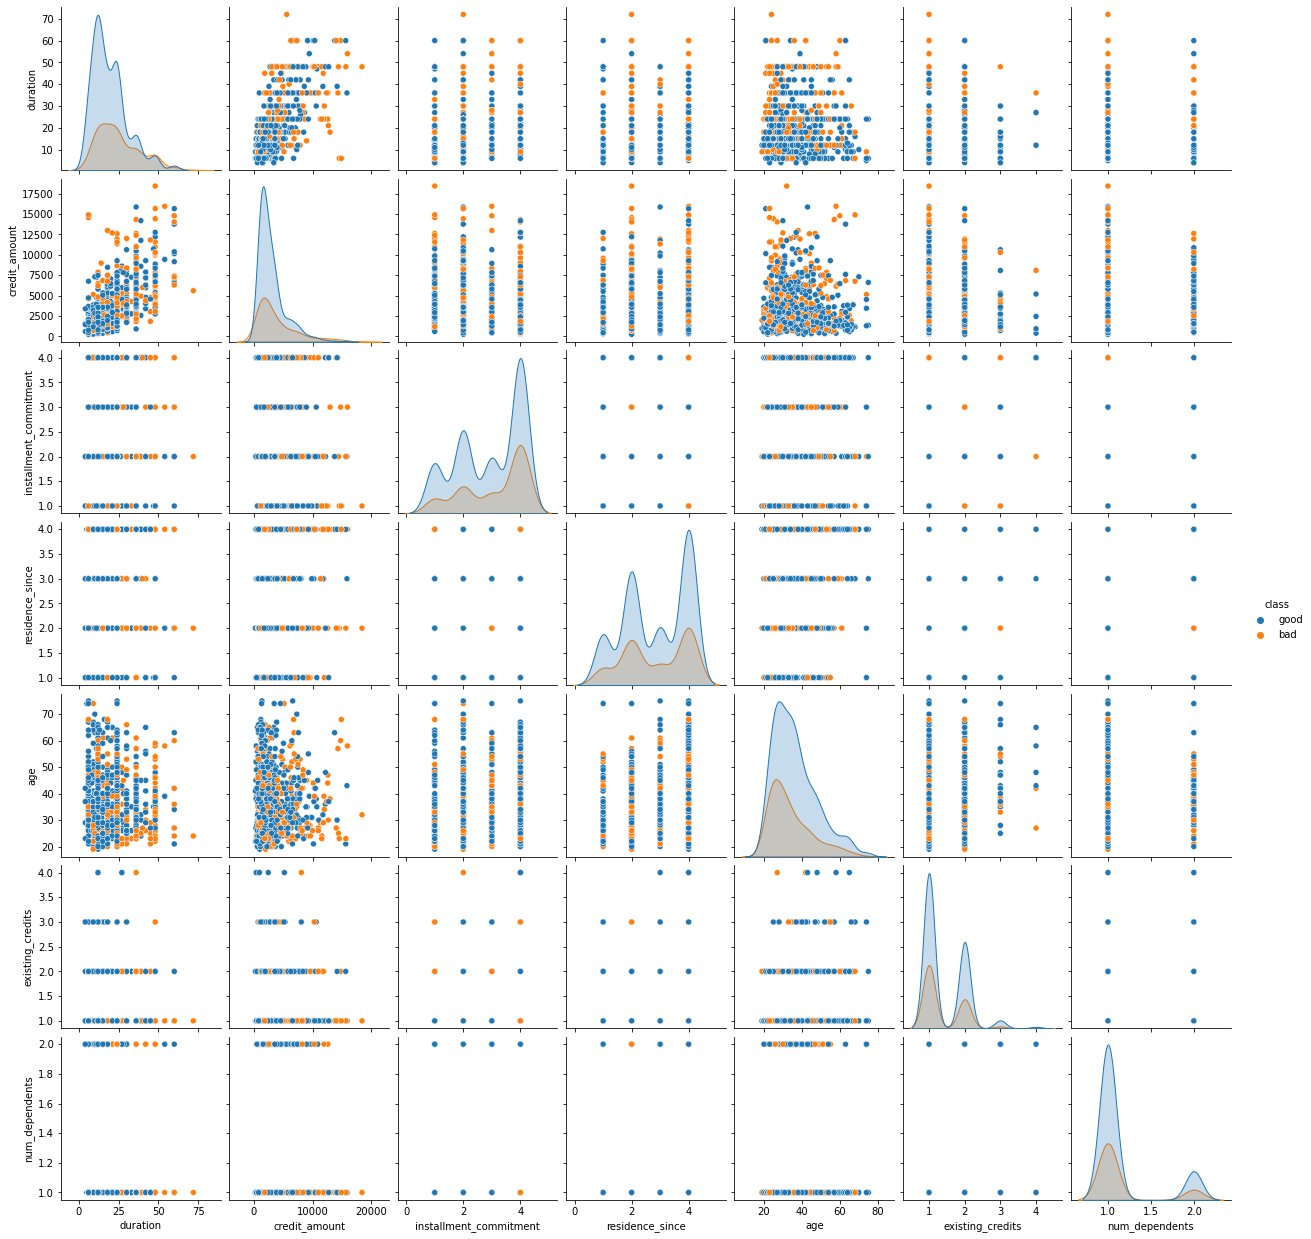

In [9]:
combined_X = pd.concat([X,y], axis=1)
sns.pairplot(combined_X, hue='class')

<b>Take-aways:</b>  
1. Minor class imbalance, might have to deal with that depending on model scores.  
2. Correlation beween credit_amount and duration exist.  Makes sense, higher is credit taken out, longer it'll take to pay it.  
3. Will create 2 subset, including both columns and dropping duration.  
4. No outliers.  
5. No obvious linear separation between features and classification, Linear models might struggle

# Categorical Features

In [10]:
cat = X.select_dtypes(exclude=np.number).columns.values.tolist()
X[cat].head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
0,<0,critical/other existing credit,radio/tv,no known savings,>=7,male single,none,real estate,none,own,skilled,yes,yes
1,0<=X<200,existing paid,radio/tv,<100,1<=X<4,female div/dep/mar,none,real estate,none,own,skilled,none,yes
2,no checking,critical/other existing credit,education,<100,4<=X<7,male single,none,real estate,none,own,unskilled resident,none,yes
3,<0,existing paid,furniture/equipment,<100,4<=X<7,male single,guarantor,life insurance,none,for free,skilled,none,yes
4,<0,delayed previously,new car,<100,1<=X<4,male single,none,no known property,none,for free,skilled,none,yes


Can break out marital status and sex into 2 columns

In [11]:
X[['sex', 'marital_status']] = X['personal_status'].str.split(expand=True)
X.drop(columns='personal_status', inplace=True)
cat.remove('personal_status')
cat.extend(['sex', 'marital_status'])
X[cat].nunique()

checking_status         4
credit_history          5
purpose                10
savings_status          5
employment              5
other_parties           3
property_magnitude      4
other_payment_plans     3
housing                 3
job                     4
own_telephone           2
foreign_worker          2
sex                     2
marital_status          4
dtype: int64

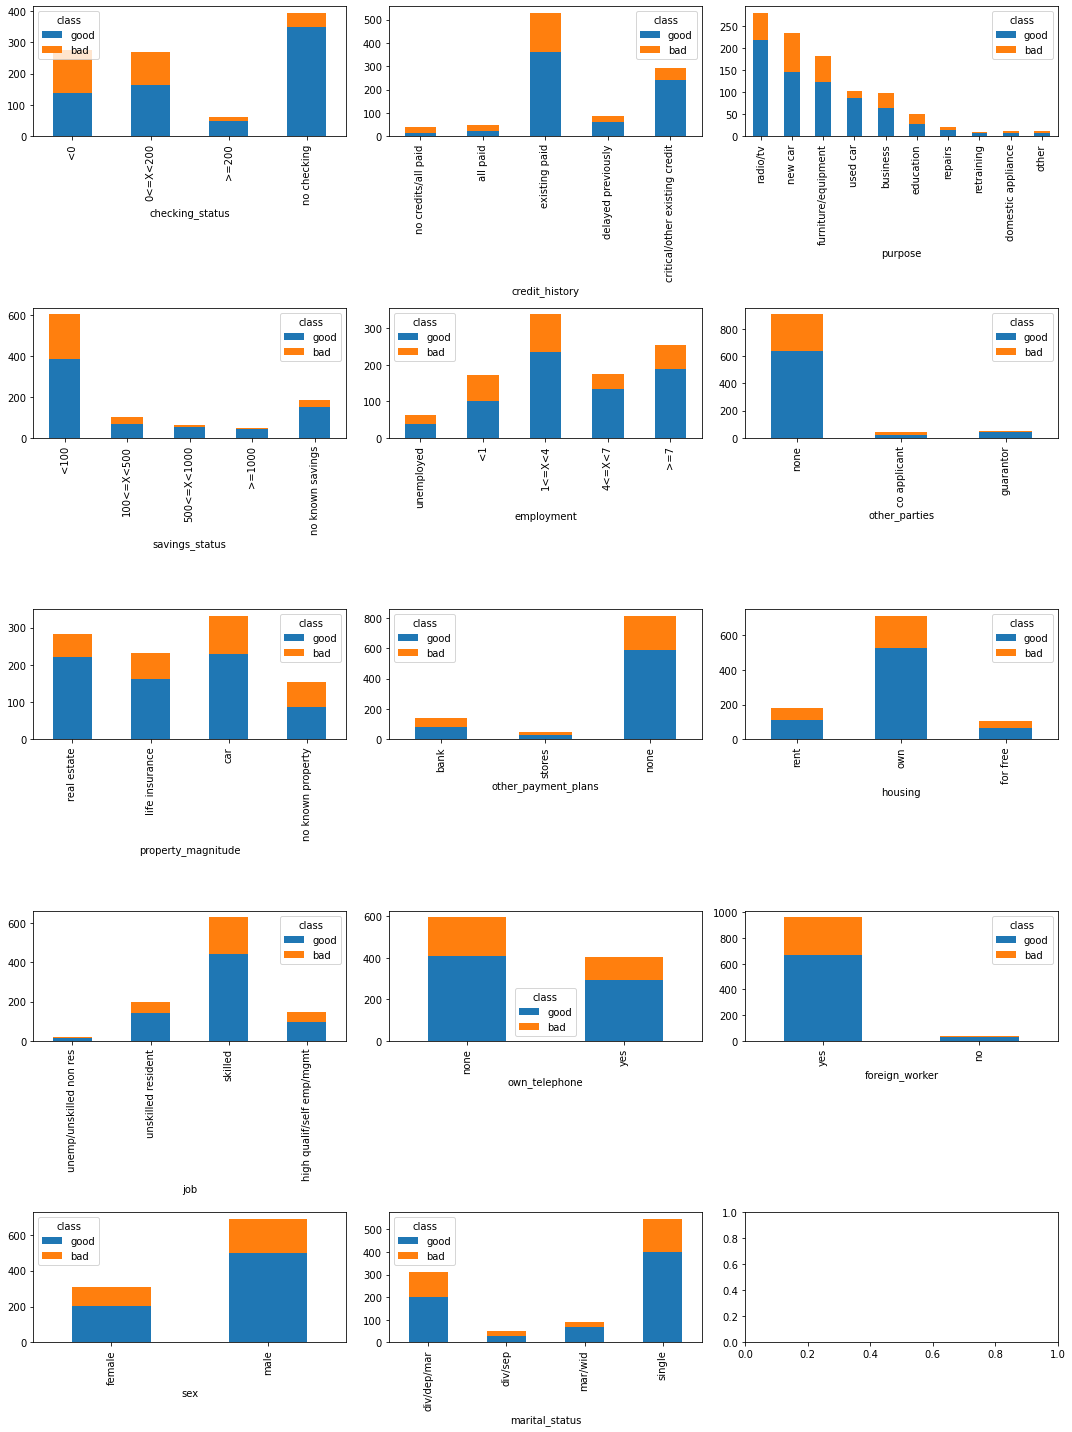

In [12]:
combined_X = pd.concat([X, y], axis=1)
fig, axs = plt.subplots(5, 3, figsize=(15, 20))
for col, ax in zip(cat, axs.ravel()):
    combined_X[[col, 'class']].value_counts().unstack().plot(kind='bar', stacked=True, ax=ax)

fig.tight_layout()

<b>Take-aways:</b>  
1. Nothing of note that jumps out from this analysis  
2. More males taking are applying for credit  
3. Majority foreign workers  

# Logistic Regression

## Model Tuning

In [13]:
#building base models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#its worse to miss-class bad than good, therefore good will be a positive class
#Selecting positive and negative class are arbitrary, not normally minority is positive
#For this project majority was selected as positive, but nothing regarding the model's performance will change
y.replace({'good':1, 'bad':0}, inplace=True)

#will split into tran, val and test.  Need validation set to calibrate probabilities later
#Setting shuffle to false, that way will split in stratified fashion with similar class percentages in train and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, shuffle=False, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, shuffle=False, random_state=0)

#printing positive class fractions
y_total_frac = y.sum()/len(y)
y_train_frac = y_train.sum() / len(y_train)
y_test_frac = y_test.sum() / len(y_test)
y_val_frac = y_val.sum() / len(y_val)
fracs = [y_total_frac, y_train_frac, y_test_frac, y_val_frac]
for set_name, frac in zip(['Target', 'Train', 'Test', 'Validation'], fracs):
    print(f'{set_name} set positive class fraction: {frac:.0%}')
base_score = y_total_frac
print(f'Models will be considered valuable if accuracy exceeds majority class frequency {base_score:.0%}')    

Target set positive class fraction: 70%
Train set positive class fraction: 71%
Test set positive class fraction: 69%
Validation set positive class fraction: 67%
Models will be considered valuable if accuracy exceeds majority class frequency 70%


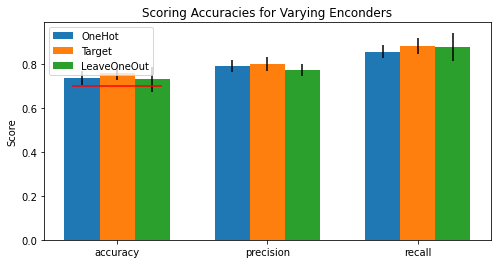

In [14]:
from sklearn.model_selection import GridSearchCV

#will try 3 encoders for categorical columns:
#One Hot - expands the table, more variables to fit --> longer fit time
#Target - keeps same column structure, faster, but leaks target information
#LeaveOneOut - similar to target but excludes conversion row during encoding

ct = ColumnTransformer([('cat', LeaveOneOutEncoder(), cat)], remainder='passthrough')

#since logistic regression is penalized need to scale all variables so penalties are scored faily for all features
pipe = Pipeline([('ct', ct),
                 ('scaler', StandardScaler()),
                 ('model', LogisticRegression(n_jobs=-1))])

param_grid = {'ct__cat':[OneHotEncoder(), TargetEncoder(), LeaveOneOutEncoder()]}
encoders = ['OneHot', 'Target', 'LeaveOneOut']
scoring=['accuracy', 'precision', 'recall']

#need to set refit to false with multiple scorings
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, 
                    scoring=scoring, n_jobs=-1, refit=False)

grid.fit(X_train, y_train)

#plotting encoder results
fig, ax = plt.subplots(figsize=(8,4))
x_labels = np.arange(len(scoring))
width = 0.7
bar_offset = width/3

for i in range(len(encoders)):
    height = [grid.cv_results_[f'mean_test_{j}'][i] for j in scoring]
    errs = [grid.cv_results_[f'std_test_{j}'][i] for j in scoring]
    ax.bar(x=x_labels - bar_offset, height=height, width=width/3, label=encoders[i], yerr=errs)
    bar_offset -= width/3
    ax.set_xticks(x_labels)
    ax.set_xticklabels(scoring)
    ax.legend()

ax.hlines(base_score, -.3, 0.3, colors='red')
name_plot(ax, 'Scoring Accuracies for Varying Enconders', y_label='Score')

<b>Take-aways:</b>  
1. All three econders result in higher than base accuracy score (red line)  
2. Precision - how many of classified events are trully events.    
3. Recall - how many positives have captured out of all

<b>Classes are imbalanced and there are 3 ways to deal with imbalance:</b>  
1. Undersample - undersample majority class so it's the same size as minority. Lose traininig data with that  
2. Oversample - sample minority class more to make the two equal size. More data to train on, takes longer with larger data sets.  
3. Class Weights - similar to oversampling, but much faster. Adds weights to loss function that balance frequency imbalance.  

<b>Since we are given the cost matrix, will use that as class weights below, class weights should be adjusted accordingly</b>  
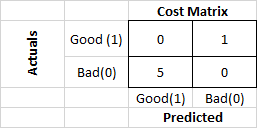  

Below is the illustration of class balancing without cost matrix.  Otherwise will substitute class weights with costs going forward

In [15]:
from sklearn.metrics import classification_report

#setting up final column transformer and pipeline for Logistic Regression
lr_ct = ColumnTransformer([('cat', TargetEncoder(), cat)], remainder='passthrough')

#Now will train all 3 models on full training set and pick the best
elastic_pipe = Pipeline([('ct', lr_ct),
                         ('scaler', StandardScaler()),
                         ('model', LogisticRegression(n_jobs=-1, penalty='elasticnet', 
                                                        solver='saga', l1_ratio=0.9))])
l1_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', LogisticRegression(penalty='l1', 
                                                 solver='liblinear'))])
l2_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', LogisticRegression(n_jobs=-1))])

pipes = [elastic_pipe, l1_pipe, l2_pipe]
print('Models without balanced class weights:\n')
for model, pipe in zip(['Elastic', 'L1', 'L2'], pipes):
    print(f'{model} Scores')
    pipe.fit(X_train, y_train)
    print(classification_report(y_train, pipe.predict(X_train), target_names=['Bad', 'Good']))
    
#Since classes are imbalanced will set class weight property on LR to balanced to account for that
print('\nModels with balanced class weights:\n')
for model, pipe in zip(['Elastic', 'L1', 'L2'], pipes):
    pipe.set_params(model__class_weight = 'balanced')
    print(f'{model} Scores')
    pipe.fit(X_train, y_train)
    print(classification_report(y_train, pipe.predict(X_train),  target_names=['Bad', 'Good']))

Models without balanced class weights:

Elastic Scores
              precision    recall  f1-score   support

         Bad       0.70      0.53      0.61       161
        Good       0.83      0.91      0.87       401

    accuracy                           0.80       562
   macro avg       0.76      0.72      0.74       562
weighted avg       0.79      0.80      0.79       562

L1 Scores
              precision    recall  f1-score   support

         Bad       0.70      0.53      0.61       161
        Good       0.83      0.91      0.87       401

    accuracy                           0.80       562
   macro avg       0.76      0.72      0.74       562
weighted avg       0.79      0.80      0.79       562

L2 Scores
              precision    recall  f1-score   support

         Bad       0.69      0.53      0.60       161
        Good       0.83      0.90      0.86       401

    accuracy                           0.80       562
   macro avg       0.76      0.72      0.73       562

<b>Take-aways:</b>  
1. All 3 models performed similarly  
2. Macro average precision is lower on weighted classes, but positive class precision is higher  
3. Macro average recall is higher, that implies that we are capturing more correct labels  
4. Accuracy accross the board is higher than majority class frequency, therefore models are reasonable

<b>Notes:</b>  
Metrics could be thershold-based:  
1. Accuracy - terrible for imbalanced sets, not usually used (how many labels were correct in total)  
2. Precision - % of positive predictions that are actually positive (same for negative class)  
3. Recall - % of true positives captured (same for negatives)  
4. F1 - harmonic average for Precision and Recall (combined score for both metrics)  
5. All the metrics could be macro averaged (sum metric for both classes and devide by 2 in binary case) or weighted (not as useful)  
  
  
Metrics could be ranking based, since ROC and PR curves try all the thresholds for decision boundary they care for ranking of points:  
1. Average precision - area under Precision Recall curve  
2. AUC - area under ROC curve.  AUC will equate 0.5 for random guess model  
  
Will grid search to optimize average precision, since thresholds can be calibrated later preferable to use ranking based metrics because they are independent of thresholds

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not conv

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

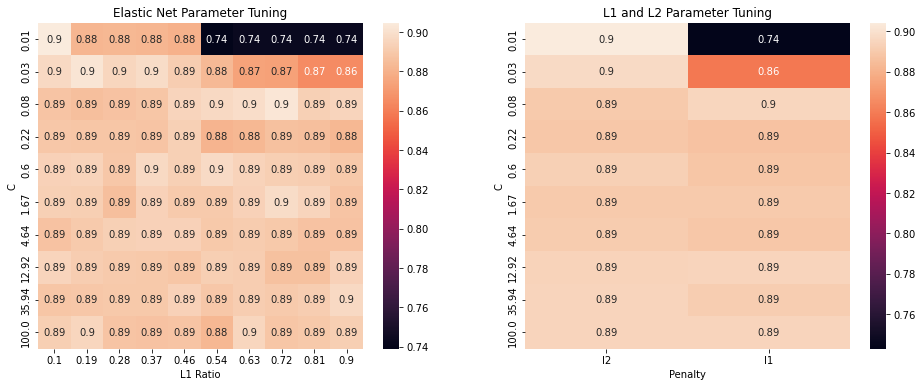

In [16]:
#class weights for misslassifying
class_weights = {1:1, 0:5}

lr_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', LogisticRegression(n_jobs=-1, penalty='elasticnet', 
                                                 solver='saga', class_weight=class_weights))])

#will utilize Multi-Fidelity search for model tuning
#take a small sample of train data and find optimum settings, they should be reflective of the full data set
X_subsample, _, y_subsample, _ = train_test_split(X_train, y_train, shuffle=False, train_size=0.25)

#will first optimize Elastic Net, then L1 and L2 penalties
Cs = np.logspace(-2, 2, num=10)
l1_ratios = np.linspace(0.1, 0.9, num=10)

param_grid = {'model__C': Cs, 'model__l1_ratio': l1_ratios}
#will optimize on average precision
elastic_grid = GridSearchCV(lr_pipe, param_grid=param_grid, scoring='average_precision', cv=10, n_jobs=-1)
elastic_grid.fit(X_subsample, y_subsample)

results = elastic_grid.cv_results_['mean_test_score'].reshape(len(Cs), -1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(results, xticklabels=l1_ratios.round(2), yticklabels=Cs.round(2), annot=True, ax=ax1)
name_plot(ax1, 'Elastic Net Parameter Tuning', 'L1 Ratio', 'C')

#L1, L2 penalties
#only liblinear solver supports L1 and L2 penalties
lr_pipe.set_params(model__penalty='l2', model__solver='liblinear', model__n_jobs=None)

param_grid = {'model__penalty': ['l2', 'l1'], 'model__C': Cs}
l_grid = GridSearchCV(lr_pipe, param_grid=param_grid, scoring='average_precision', cv=10, n_jobs=-1)
l_grid.fit(X_subsample, y_subsample)
results = l_grid.cv_results_['mean_test_score'].reshape(10,-1)
sns.heatmap(results, yticklabels=Cs.round(2), xticklabels=['l2', 'l1'], annot=True, ax=ax2)
name_plot(ax2, 'L1 and L2 Parameter Tuning', 'Penalty', 'C')

<b>Take-aways:</b>  
1. All three models performed similary on AP score  
2. Found tuning parameters, now will use all 3 tuned models to figure out which one scores the highest on full training set

In [17]:
elast_C, elast_l1_ratio = elastic_grid.best_params_.values()

print(f'Elastic Net Best C: {elast_C}, Best L1 Ratio: {elast_l1_ratio}')
l1_scores = l_grid.cv_results_['mean_test_score'][1::2]
best_l1_score = np.argmax(l1_scores)
l2_scores = l_grid.cv_results_['mean_test_score'][::2]
best_l2_score = np.argmax(l2_scores)
l1_C = Cs[best_l1_score]
l2_C = Cs[best_l2_score]
print(f'L2 best C: {l2_C}')
print(f'L1 best C: {l1_C}')

Elastic Net Best C: 0.01, Best L1 Ratio: 0.1
L2 best C: 0.01
L1 best C: 0.0774263682681127


## Model Evaluation

In [18]:
#Now will train all 3 models on full training set and pick the best
elastic_pipe = Pipeline([('ct', lr_ct),
                         ('scaler', StandardScaler()),
                         ('model', LogisticRegression(n_jobs=-1, penalty='elasticnet', 
                                                      solver='saga', class_weight=class_weights,
                                                      C=elast_C, l1_ratio=elast_l1_ratio))])
l1_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', LogisticRegression(penalty='l1', class_weight=class_weights,
                                                 solver='liblinear', C=l1_C))])
l2_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', LogisticRegression(n_jobs=-1, C=l2_C, class_weight=class_weights))])

pipes = [elastic_pipe, l1_pipe, l2_pipe]
models = ['Elastic', 'L1', 'L2']
print('Calibrated Model Train CV Scores')
for model, pipe in zip(models, pipes):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'{model} Scores')
    print(classification_report(y_test, y_pred, target_names=['Bad', 'Good']))

Calibrated Model Train CV Scores
Elastic Scores
              precision    recall  f1-score   support

         Bad       0.44      0.88      0.59        77
        Good       0.91      0.50      0.64       173

    accuracy                           0.62       250
   macro avg       0.67      0.69      0.61       250
weighted avg       0.76      0.62      0.62       250

L1 Scores
              precision    recall  f1-score   support

         Bad       0.46      0.86      0.60        77
        Good       0.90      0.55      0.68       173

    accuracy                           0.64       250
   macro avg       0.68      0.70      0.64       250
weighted avg       0.76      0.64      0.66       250

L2 Scores
              precision    recall  f1-score   support

         Bad       0.44      0.88      0.59        77
        Good       0.91      0.51      0.65       173

    accuracy                           0.62       250
   macro avg       0.68      0.70      0.62       250
weight

<b>Take-aways:</b>  
1. Using validation set to compare the models  
2. All 3 models performed similar across the board, but L1 f1 score is slightly higher  
3. Need to evaluate AP and AUC to compare the models overall performaces 

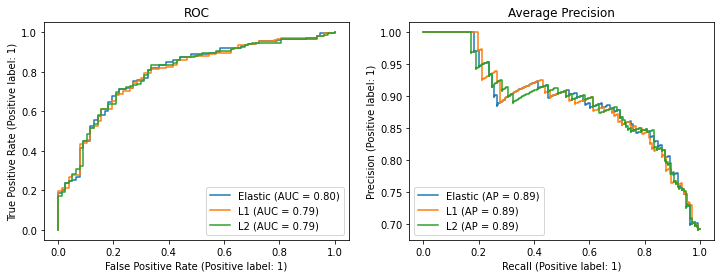

In [19]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, roc_curve

#will plot ROC and PR curves for all 3 models
fig, (roc_ax, pr_ax) = plt.subplots(1, 2, figsize=(12, 4))

name_plot(roc_ax, 'ROC')
for model, pipe in zip(models, pipes):
    plot_roc_curve(pipe, X_test, y_test, response_method='predict_proba', ax=roc_ax, name=model)
    
name_plot(pr_ax, 'Average Precision')    
for model, pipe in zip(models, pipes):
    plot_precision_recall_curve(pipe, X_test, y_test, response_method='predict_proba', ax=pr_ax, name=model)

<b>Take-aways:</b>  
1. AUC is above 50% therefore better than chance predictions.  
2. Normally pick the model with the highest AUC, but all 3 models have similar scores, so picking the simplest is the key  
3. Decision thresholds can be adjusted to relax the probabilites for positive classes

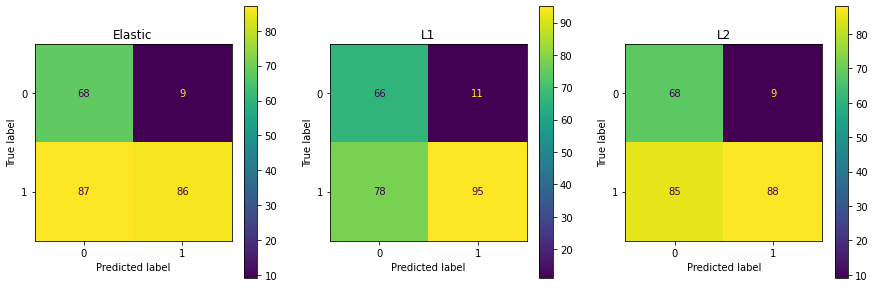

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for model, pipe, ax in zip(models, pipes, axs.ravel()):
    plot_confusion_matrix(pipe, X_test, y_test, ax=ax)
    ax.set_title(f'{model}')

Since our bad class weight x5 of good, we get a small amount of false positives. That was the goal of the cost matrix, therefore it's fine.  

The best decision threshold is usually the one closest to top left corner on ROC (100 TPR and 0 FPR), therefore will pick L1 model and find the decision thershold closest to top left

              precision    recall  f1-score   support

           0       0.55      0.73      0.63        77
           1       0.86      0.74      0.80       173

    accuracy                           0.74       250
   macro avg       0.71      0.73      0.71       250
weighted avg       0.77      0.74      0.74       250



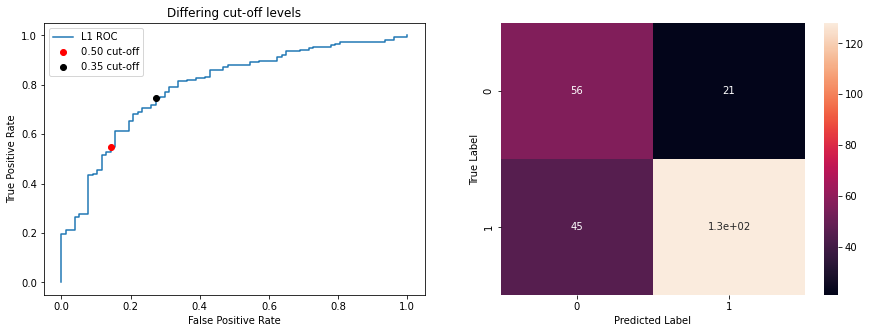

In [21]:
from sklearn.metrics import confusion_matrix
fpr, tpr, thresh = roc_curve(y_test, l1_pipe.predict_proba(X_test)[:,1])
#finding 0.5 threshold
cut_off_poss = np.isclose(thresh, 0.5, rtol=0.01).argmax()
cut_off = thresh[cut_off_poss]
#finding closest point to top left corner
best_cut_off_pos = (((1-tpr) ** 2 + (fpr)**2)**0.5).argmin()
best_cut_off = thresh[best_cut_off_pos]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(fpr, tpr, label='L1 ROC')
ax1.plot(fpr[cut_off_poss], tpr[cut_off_poss], 'or', label=f'{cut_off:.2f} cut-off')
ax1.plot(fpr[best_cut_off_pos], tpr[best_cut_off_pos], 'ok', label=f'{best_cut_off:.2f} cut-off')
ax1.legend()
ax1.set_title('Differing cut-off levels')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

#changin positive threshold to best one found
y_pred = l1_pipe.predict_proba(X_test)[:,1] > best_cut_off
cnf_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_mtx, annot=True, ax=ax2)
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

print(classification_report(y_test, y_pred))
plt.show()

#now need to 

Best cut-off is 35% to classify a point as positive.  
F1 Score has drastically improved and we've captured a lot more True Positives, however estimating costs from cost matrix indicates the total cost for this threshold is 150, while L1 cost from 50% threshold is 133

## Model Probability Calibraions

<b>Model probabilities, should be calibrated.  Logistic regression models are usually well calibrated because they are built to maximize likelihood estimates.

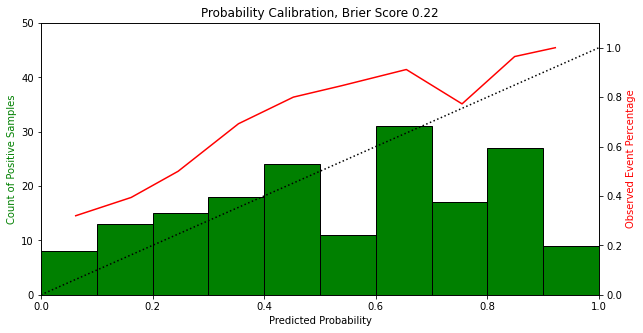

In [22]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

y_prob = l1_pipe.predict_proba(X_test)[:,1]
prob_true, prob_predict = calibration_curve(y_test, y_prob, n_bins=10)
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax.hist(y_prob, bins=10, range=(0,1), weights=y_test, edgecolor='black', color='green')
ax.set_ylim(0,50)

ax2.plot(prob_predict, prob_true, 'r')
ax2.set_ylim(0,1.1)
ax2.set_xlim(0,1)
ax2.plot([0, 1], [0, 1], ':k')

br_score = brier_score_loss(y_test, y_prob)
ax2.set_ylabel('Observed Event Percentage', color='red')
name_plot(ax, f'Probability Calibration, Brier Score {br_score:.2f}', 'Predicted Probability')
ax.set_ylabel('Count of Positive Samples', color='green')

plt.show()

Curve dipping below the line --> over confident  
Curve rising above the line --> not as confident  
Lower Brier score is better  
Since class weights have been adjusted to account for cost matrix, probabilities won't match up with underlying distribution for 2 reason:  
1. Class imbalance  
2. Cost matrix  
  
Probabilities response makes sense.  Since we've increased the weight of missclassifying bad to 5 and good to 1, the model not as certain in identifying good credit customers.

# SVC/Random Forest

Text(0.5, 15.0, 'Cs')

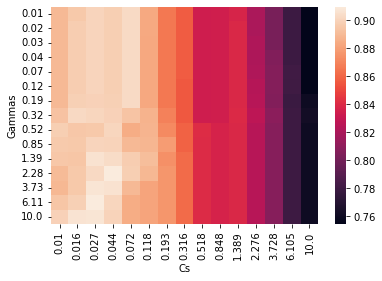

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

svc_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', SVC(class_weight=class_weights))])

gb_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', GradientBoostingClassifier())])

Cs= np.logspace(-2, 1, 15)
gammas= np.logspace(-2, 1, 15)

grid_params = {'model__C':Cs,
               'model__gamma':gammas}

grid = GridSearchCV(svc_pipe, grid_params, scoring='average_precision', cv=10)
grid.fit(X_subsample, y_subsample)
results = grid.cv_results_['mean_test_score'].reshape(15,-1)

#set best params in SVC
svc_pipe.set_params(**grid.best_params_)

sns.heatmap(results, xticklabels=Cs.round(3), yticklabels=gammas.round(2))
plt.gca().set_ylabel('Gammas')
plt.gca().set_xlabel('Cs')

              precision    recall  f1-score   support

           0       0.52      0.64      0.57        77
           1       0.82      0.73      0.77       173

    accuracy                           0.70       250
   macro avg       0.67      0.69      0.67       250
weighted avg       0.73      0.70      0.71       250



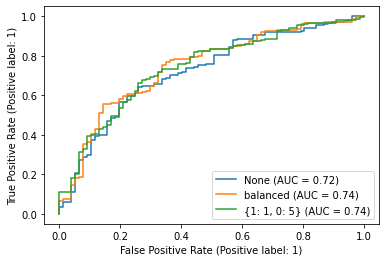

In [25]:
#Checking the impact of class weights on ROC AUC
fig, ax = plt.subplots()
for weights in [None, 'balanced', {1:1, 0:5}]:
    svc_pipe.set_params(model__class_weight = weights)
    svc_pipe.fit(X_train, y_train)
    plot_roc_curve(svc_pipe, X_test, y_test, ax=ax, name=weights or 'None')
    

print(classification_report(y_test, svc_pipe.predict(X_test)))

All points are classed as negative class, need to adjust decision function point

              precision    recall  f1-score   support

           0       0.50      0.73      0.59        77
           1       0.85      0.67      0.75       173

    accuracy                           0.69       250
   macro avg       0.67      0.70      0.67       250
weighted avg       0.74      0.69      0.70       250

Best Threshold: 0.242


Text(0.5, 15.0, 'Predicted Label')

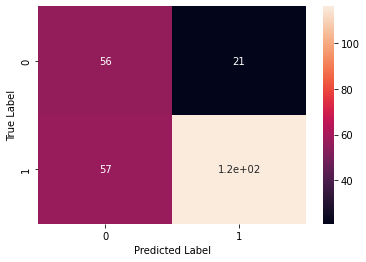

In [26]:
fpr, tpr, thresh = roc_curve(y_test, svc_pipe.decision_function(X_test))
best_thresh_pos = (((1-tpr)**2 + fpr**2)**.5).argmin()
y_pred = svc_pipe.decision_function(X_test) > thresh[best_thresh_pos]
print(classification_report(y_test, y_pred))
print(f'Best Threshold: {thresh[best_thresh_pos]:.3f}')
cnf_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_mtx, annot=True)
plt.gca().set_ylabel('True Label')
plt.gca().set_xlabel('Predicted Label')

Macro F1 average is slightly higher than Logistic Regression

In [27]:
#tuning number of trees in random forest
rf_pipe = Pipeline([('ct', lr_ct),
                    ('scaler', StandardScaler()),
                    ('model', RandomForestClassifier(class_weight=class_weights))])

rf_base_score = cross_val_score(rf_pipe, X_train, y_train, scoring='roc_auc', cv=10).mean()
print(f'Base Random Forest ROC AUC: {rf_base_score:.3f}')

Base Random Forest ROC AUC: 0.783


Text(0.5, 1.0, 'Searching for best # of Estimators')

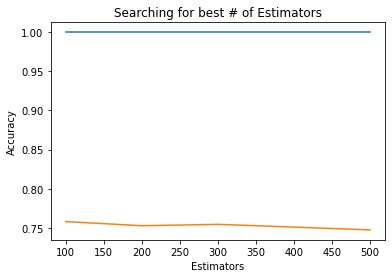

In [28]:
rf_pipe.set_params(model__warm_start=True, model__oob_score=True)
oob_scores = []
trees = np.arange(100, 501, 100)
train_scores = []
for estimators in trees:
    rf_pipe.set_params(model__n_estimators = estimators)
    rf_pipe.fit(X_train, y_train)
    train_scores.append(rf_pipe.score(X_train, y_train))
    oob_scores.append(rf_pipe.named_steps['model'].oob_score_)

fig, ax = plt.subplots()
ax.plot(trees, train_scores, label='Train Score')
ax.plot(trees, oob_scores, label='OOB Scores')
ax.set_xlabel('Estimators')
ax.set_ylabel('Accuracy')
ax.set_title('Searching for best # of Estimators')

Best # of Features: 7


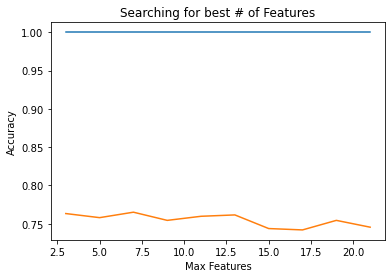

In [29]:
rf_pipe.set_params(model__warm_start = False, model__n_estimators=300)
max_features = np.arange(3, X_train.shape[1]+1, 2)
oob_scores = []
train_scores = []
for feat in max_features:
    rf_pipe.set_params(model__max_features = feat)
    rf_pipe.fit(X_train ,y_train)
    train_scores.append(rf_pipe.score(X_train, y_train))
    oob_scores.append(rf_pipe.named_steps['model'].oob_score_)
    
fig, ax = plt.subplots()
ax.plot(max_features, train_scores, label='Train Score')
ax.plot(max_features, oob_scores, label='OOB Scores')
ax.set_xlabel('Max Features')
ax.set_ylabel('Accuracy')
ax.set_title('Searching for best # of Features')
best_feat = max_features[np.argmax(oob_scores)]
print(f'Best # of Features: {best_feat}')

              precision    recall  f1-score   support

           0       0.50      0.75      0.60        77
           1       0.86      0.66      0.75       173

    accuracy                           0.69       250
   macro avg       0.68      0.71      0.68       250
weighted avg       0.75      0.69      0.70       250

Best Threshold: 0.747


Text(0.5, 15.0, 'Predicted Label')

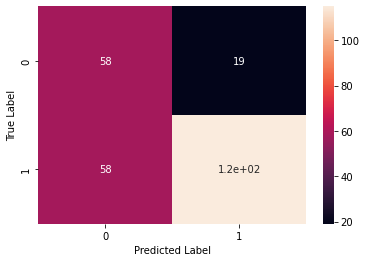

In [30]:
rf_pipe.set_params(model__max_features = best_feat)
rf_pipe.fit(X_train, y_train)

fpr, tpr, thresh = roc_curve(y_test, rf_pipe.predict_proba(X_test)[:,1])
best_thresh_pos = (((1-tpr)**2 + fpr**2)**.5).argmin()
y_pred = rf_pipe.predict_proba(X_test)[:,1] > thresh[best_thresh_pos]
print(classification_report(y_test, y_pred))
print(f'Best Threshold: {thresh[best_thresh_pos]:.3f}')
cnf_mtx = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_mtx, annot=True)
plt.gca().set_ylabel('True Label')
plt.gca().set_xlabel('Predicted Label')

Text(0, 0.5, 'True Probability')

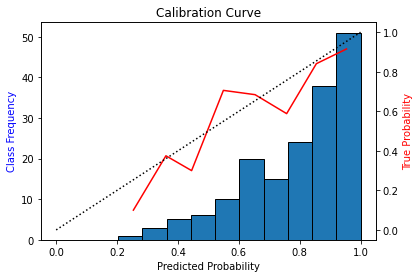

In [31]:
prob_true, prob_pred = calibration_curve(y_test, rf_pipe.predict_proba(X_test)[:,1], n_bins=10)
fig, ax = plt.subplots()
y_prob = rf_pipe.predict_proba(X_test)[:,1]
ax.hist(y_prob, bins=10, weights=y_test, edgecolor='black')

ax2 = ax.twinx()
ax2.plot(prob_pred, prob_true, 'r', label='Calibration Curve')
ax2.plot([0,1], [0,1], ':k')
ax.set_title('Calibration Curve')
ax.set_ylabel('Class Frequency', color='blue')
ax.set_xlabel('Predicted Probability')
ax2.set_ylabel('True Probability', color='red')

Text(0.5, 1.0, 'Permutation Feature Importances')

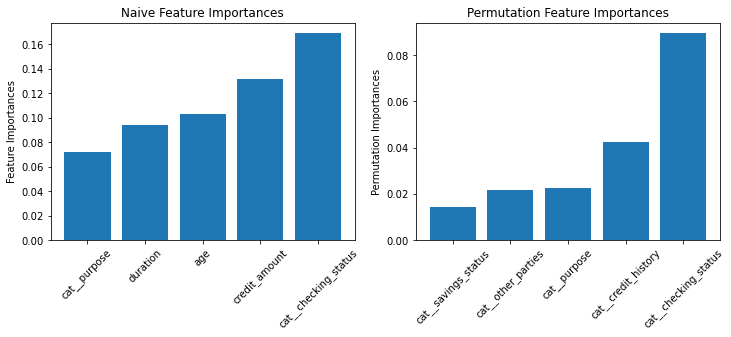

In [32]:
from sklearn.inspection import permutation_importance
feature_names = np.array(rf_pipe.named_steps['ct'].get_feature_names())
naive_fi = rf_pipe.named_steps['model'].feature_importances_ 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.bar(feature_names[naive_fi.argsort()[-5:]], naive_fi[naive_fi.argsort()[-5:]])
ax1.tick_params('x', rotation=45)
ax1.set_ylabel('Feature Importances')
ax1.set_title('Naive Feature Importances')

importances = permutation_importance(rf_pipe, X_test, y_test)['importances_mean']
ax2.bar(feature_names[importances.argsort()[-5:]], importances[importances.argsort()[-5:]])
ax2.tick_params('x', rotation=45)
ax2.set_ylabel('Permutation Importances')
ax2.set_title('Permutation Feature Importances')

# PCA

Text(0.5, 1.0, 'PCA')

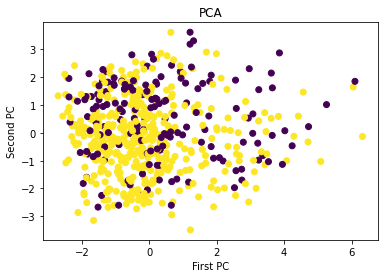

In [33]:
from sklearn.decomposition import PCA

#need to scale the data before performing PCA
pca = Pipeline([('ct', ct), ('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
X_pca = pca.fit_transform(X_train, y_train)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train)
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.title('PCA')

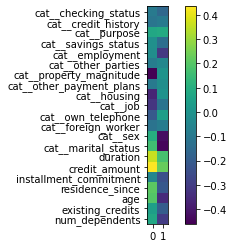

In [34]:
plt.imshow(pca.named_steps['pca'].components_.T)
plt.yticks(range(X_train.shape[1]), feature_names)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Variance Covered')

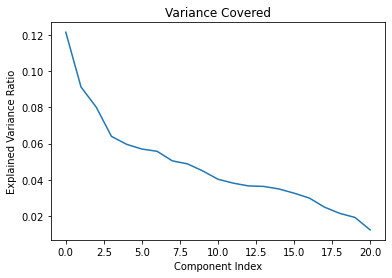

In [35]:
pca.set_params(pca__n_components=X_train.shape[1])
pca.fit(X_train, y_train)
plt.plot(pca.named_steps['pca'].explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Component Index')
plt.title('Variance Covered')